In [1]:
import numpy as np
import matplotlib.pyplot as plt

Load the matter density field (`delta`) at $z = 0$. The first 4-byte is the number of grid (`N`), and the next `N*N*N` blocks are the density field.

In [2]:
fname = "output/delta_z0_ng512.dat"

N = np.fromfile(fname, count=1, dtype=np.int32)[0]
delta = np.fromfile(fname, count=N*N*N, dtype=np.float64, offset=4)
delta = delta.reshape((N, N, N))

print("N:", N)

N: 512


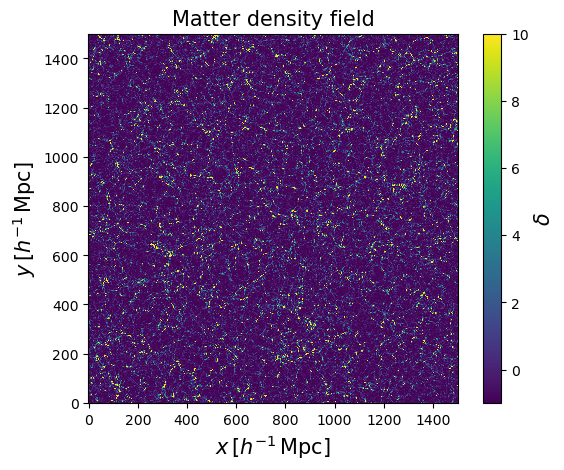

In [3]:
L = 1500.0  # Mpc/h
x = np.linspace(0.0, L, N)
X, Y = np.meshgrid(x, x, indexing="ij")

plt.pcolormesh(X, Y, delta[:, :, N//2], vmin=-1.0, vmax=10.0, rasterized=True)
plt.gca().set_aspect('equal')

plt.xlabel(r"$x \, [h^{-1} \, \mathrm{Mpc}]$", fontsize=15)
plt.ylabel(r"$y \, [h^{-1} \, \mathrm{Mpc}]$", fontsize=15)
plt.title(r"Matter density field", fontsize=15)
cb = plt.colorbar()
cb.set_label(label=r"$\delta$", fontsize=15)

plt.show()

Next, load the halo density field. The structure of the data is the same as the matter density field. In this example, load the halo density field at $z = 0$ with the halo mass $M_\mathrm{vir} = 10^{13} - 10^{13.5} \, h^{-1} \, M_\odot$.

In [4]:
fname = "output/halo_z0_ng512_M13-13.5.dat"

N = np.fromfile(fname, count=1, dtype=np.int32)[0]
deltah = np.fromfile(fname, count=N*N*N, dtype=np.float64, offset=4)
deltah = deltah.reshape((N, N, N))

print("N:", N)

N: 512


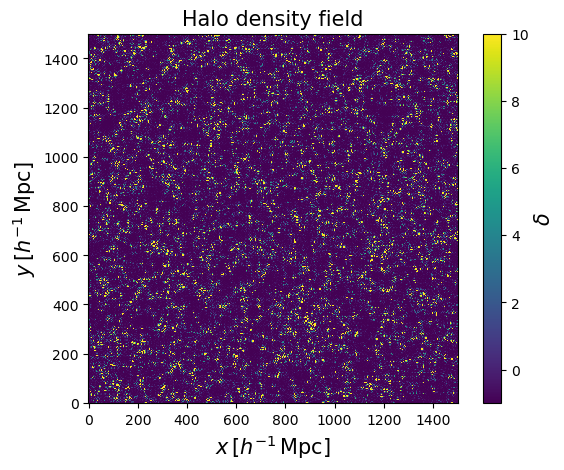

In [5]:
L = 1500.0  # Mpc/h
x = np.linspace(0.0, L, N)
X, Y = np.meshgrid(x, x, indexing="ij")

plt.pcolormesh(X, Y, deltah[:, :, N//2], vmin=-1.0, vmax=10.0, rasterized=True)
plt.gca().set_aspect('equal')

plt.xlabel(r"$x \, [h^{-1} \, \mathrm{Mpc}]$", fontsize=15)
plt.ylabel(r"$y \, [h^{-1} \, \mathrm{Mpc}]$", fontsize=15)
plt.title(r"Halo density field", fontsize=15)
cb = plt.colorbar()
cb.set_label(label=r"$\delta$", fontsize=15)

plt.show()

For sanity check, let's measure power spectra.

/tmp/ipykernel_250292/4004653748.py:11: RuntimeWarning: divide by zero encountered in log10
  Nk, bin_edges = np.histogram(np.log10(k.flatten()), range=(np.log10(kmin), np.log10(kmax)), bins=Nbin)
/tmp/ipykernel_250292/4004653748.py:13: RuntimeWarning: divide by zero encountered in log10
  kbin, _ = np.histogram(np.log10(k.flatten()), range=(np.log10(kmin), np.log10(kmax)), bins=Nbin, weights=k.flatten())
/tmp/ipykernel_250292/4004653748.py:19: RuntimeWarning: divide by zero encountered in log10
  Pkbin_m, _ = np.histogram(np.log10(k.flatten()), range=(np.log10(kmin), np.log10(kmax)), bins=Nbin, weights=Pk_m.flatten())
/tmp/ipykernel_250292/4004653748.py:25: RuntimeWarning: divide by zero encountered in log10
  Pkbin_h, _ = np.histogram(np.log10(k.flatten()), range=(np.log10(kmin), np.log10(kmax)), bins=Nbin, weights=Pk_h.flatten())


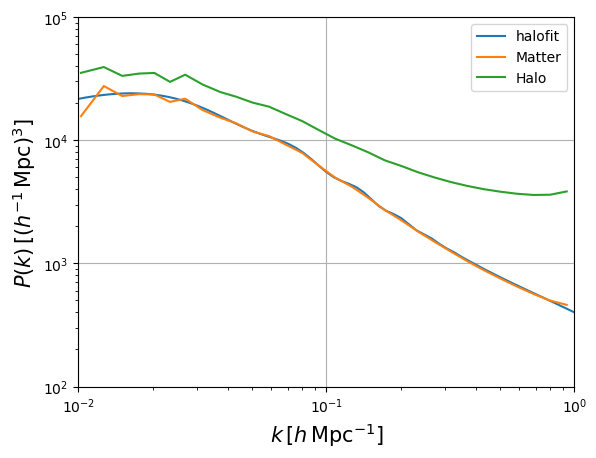

In [6]:
# define k binning
Nbin = 30
kmin = 0.01
kmax = 1.0
kny = np.pi/(L/N)

k1 = (2.0*np.pi*N/L)*np.fft.fftfreq(N)
kx, ky, kz = np.meshgrid(k1, k1, k1, indexing='ij')
k = np.sqrt(kx**2 + ky**2 + kz**2)

Nk, bin_edges = np.histogram(np.log10(k.flatten()), range=(np.log10(kmin), np.log10(kmax)), bins=Nbin)

kbin, _ = np.histogram(np.log10(k.flatten()), range=(np.log10(kmin), np.log10(kmax)), bins=Nbin, weights=k.flatten())
kbin = kbin/Nk

# measure matter power spectrum
deltak = np.fft.fftn(delta)
Pk_m = (deltak*deltak.conj()).real
Pkbin_m, _ = np.histogram(np.log10(k.flatten()), range=(np.log10(kmin), np.log10(kmax)), bins=Nbin, weights=Pk_m.flatten())
Pkbin_m = L**3*Pkbin_m/Nk/(N**6)

# measure halo power spectrum (shot noise NOT subtracted)
deltahk = np.fft.fftn(deltah)
Pk_h = (deltahk*deltahk.conj()).real
Pkbin_h, _ = np.histogram(np.log10(k.flatten()), range=(np.log10(kmin), np.log10(kmax)), bins=Nbin, weights=Pk_h.flatten())
Pkbin_h = L**3*Pkbin_h/Nk/(N**6)

# For reference, class nonlinear power spectrum
from classy import Class

params = {"output": "mPk, mTk",
            "h": 0.67321,
            "Omega_b": 0.049389,
            "Omega_cdm": 0.26499,
            "n_s": 0.96605,
            "A_s": 2.1005e-09,
            "z_pk": 0.0,
            'm_ncdm': 0.06,
            'YHe': 0.245401,
            'k_pivot': 0.05,
            'k_scalar_min_tau0': 1e-05,
            'P_k_max_h/Mpc': 100.0,
            'N_ncdm': 1,
            'N_ur': 2.046,
            'non linear': "halofit"}

cosmo = Class()
cosmo.set(params)
cosmo.compute()

k_NL = np.logspace(-2, 1, 100)
Pk_NL = np.zeros_like(k_NL)
h = params["h"]
for i in range(100):
    Pk_NL[i] = cosmo.pk(k_NL[i]*h, 0.0)*h**3


plt.loglog(k_NL, Pk_NL, label="halofit")
plt.loglog(kbin, Pkbin_m, label="Matter")
plt.loglog(kbin, Pkbin_h, label="Halo")

plt.xlabel("$k \, [h \, \mathrm{Mpc}^{-1}]$", fontsize=15)
plt.ylabel("$P(k) \, [(h^{-1} \, \mathrm{Mpc})^3]$", fontsize=15)
plt.xlim(0.01, 1.0)
plt.ylim(1e2, 1e5)
plt.grid()
plt.legend()

plt.show()